In [30]:

# 1. Handle datasets
import io
import os
import cv2
import torch
import random
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.transform import resize
from PIL import Image, ImageDraw
from pathlib import Path
from collections import Counter
from joblib import Parallel, delayed
from tqdm import tqdm
import imageio
import gc

In [15]:
parent_dir = r"E:\rsna-breast-cancer-detection"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = torch.hub.load(
    './yolov5', 
    'custom', 
    path=r"C:\Users\MINH KHAI\Healthcare_Imaging\RSNA_BreastCancer\rsna-roi-003.pt", 
    source='local'
)
model.to(device)

YOLOv5  2025-4-10 Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [16]:
torch.cuda.empty_cache()
file_list = glob(
    os.path.join(parent_dir, "train_image_processed_jp2000_512", "*", "*.jp2")
)

In [ ]:
%matplotlib inline

images = []

for path in random.sample(file_list, 25):
    frame = plt.imread(path)
    
    # Convert to PIL Image
    img_pil = Image.fromarray(frame)
    draw = ImageDraw.Draw(img_pil)

    detections = model(frame)
    results = detections.pandas().xyxy[0].to_dict(orient="records")
    
    for result in results:
        xmin, ymin = int(result['xmin']), int(result['ymin'])
        xmax, ymax = int(result['xmax']), int(result['ymax'])
        draw.rectangle([(xmin, ymin), (xmax, ymax)], outline='red', width=4)
    
    images.append(np.array(img_pil))

c:\Users\MINH KHAI\Healthcare_Imaging\RSNA_BreastCancer\yolov5\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\MINH KHAI\Healthcare_Imaging\RSNA_BreastCancer\yolov5\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\MINH KHAI\Healthcare_Imaging\RSNA_BreastCancer\yolov5\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\MINH KHAI\Healthcare_Imaging\RSNA_BreastCancer\yolov5\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
c:\Users\MINH KHAI\Healthcare_Imaging\RSNA_B

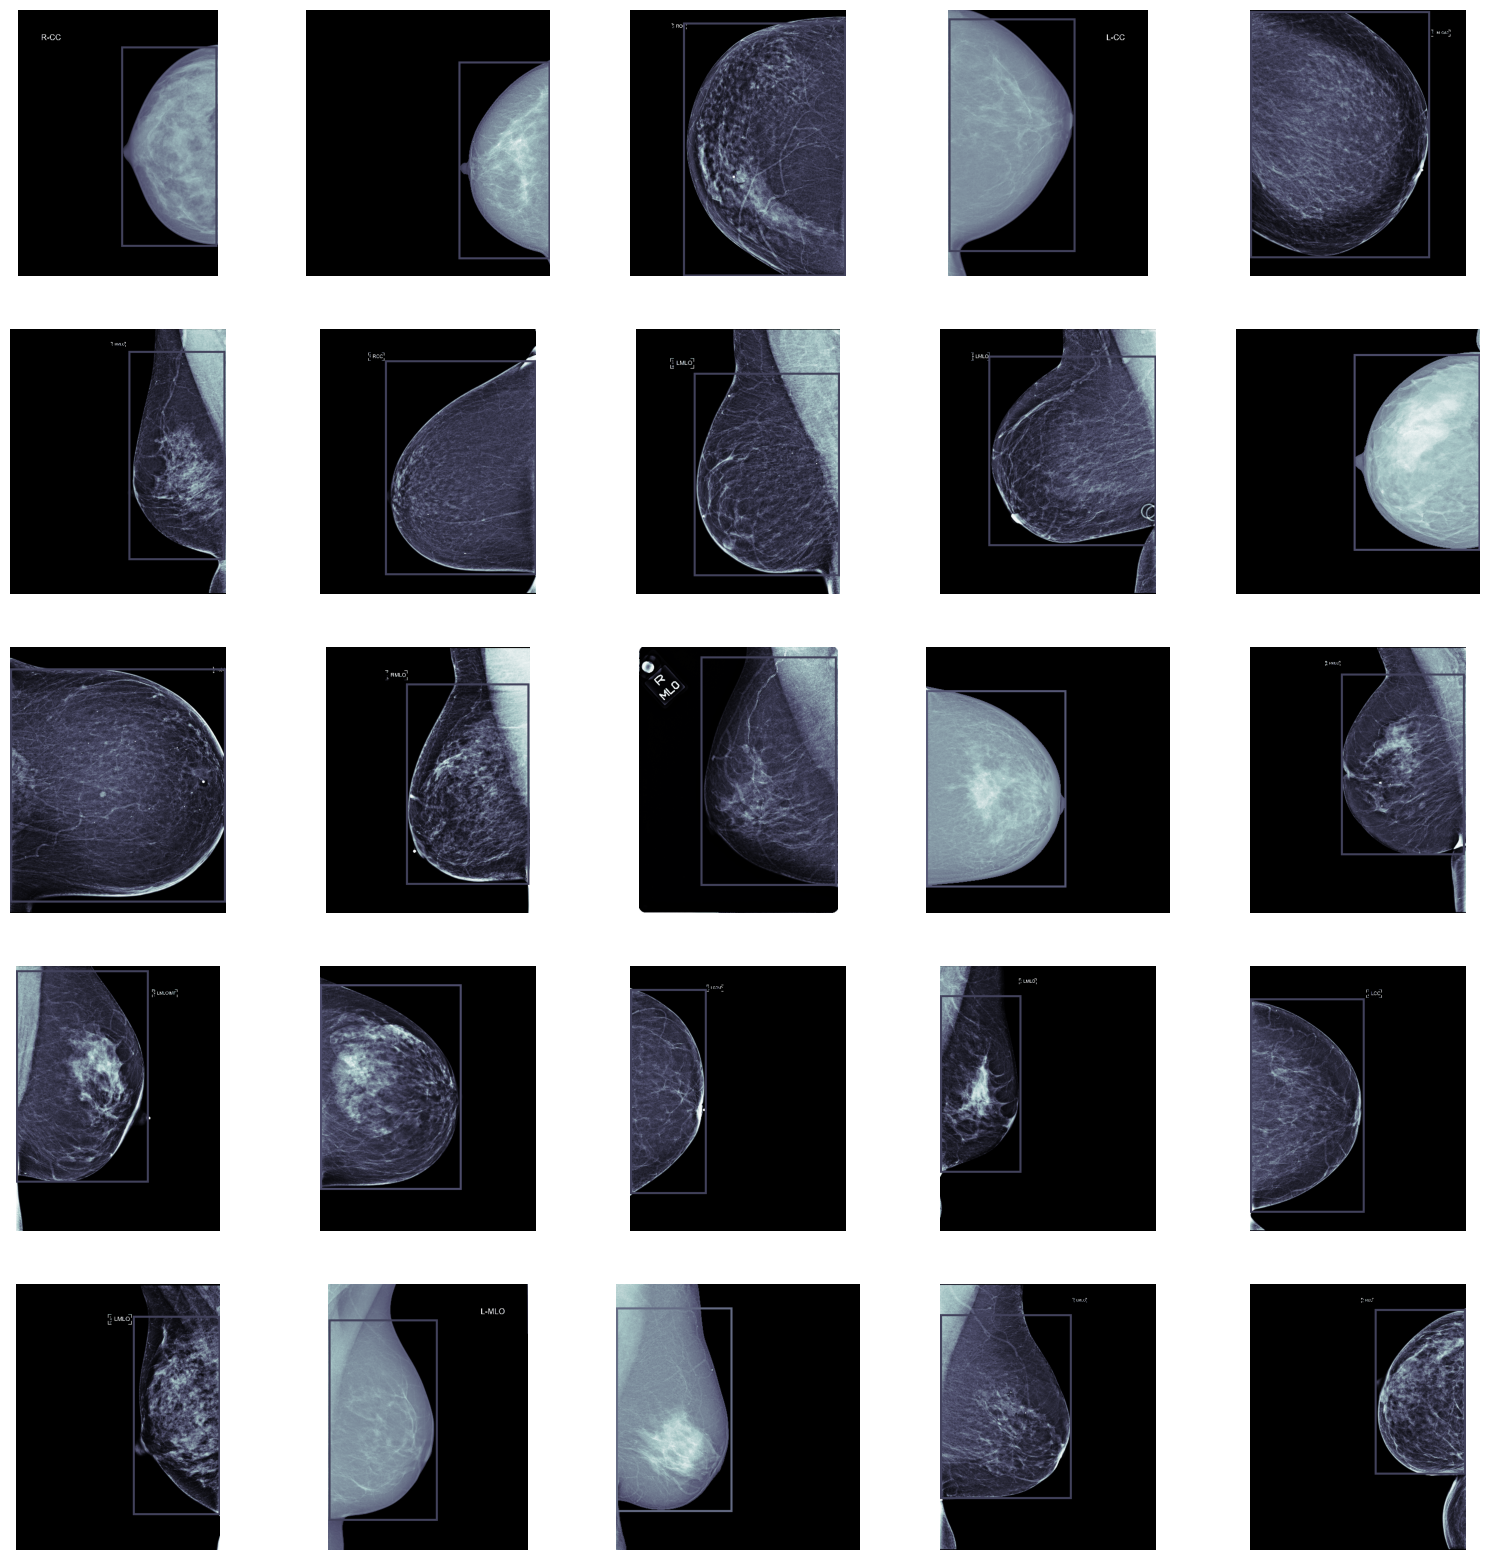

In [29]:
fig, axes = plt.subplots(5, 5, figsize=(20,20))
    
for idx, image in enumerate(images):
    i = idx % 5 
    j = idx // 5 
    axes[i, j].imshow(image, cmap="bone")
    axes[i, j].axis('off')

plt.subplots_adjust(wspace=0, hspace=.2)
plt.show()

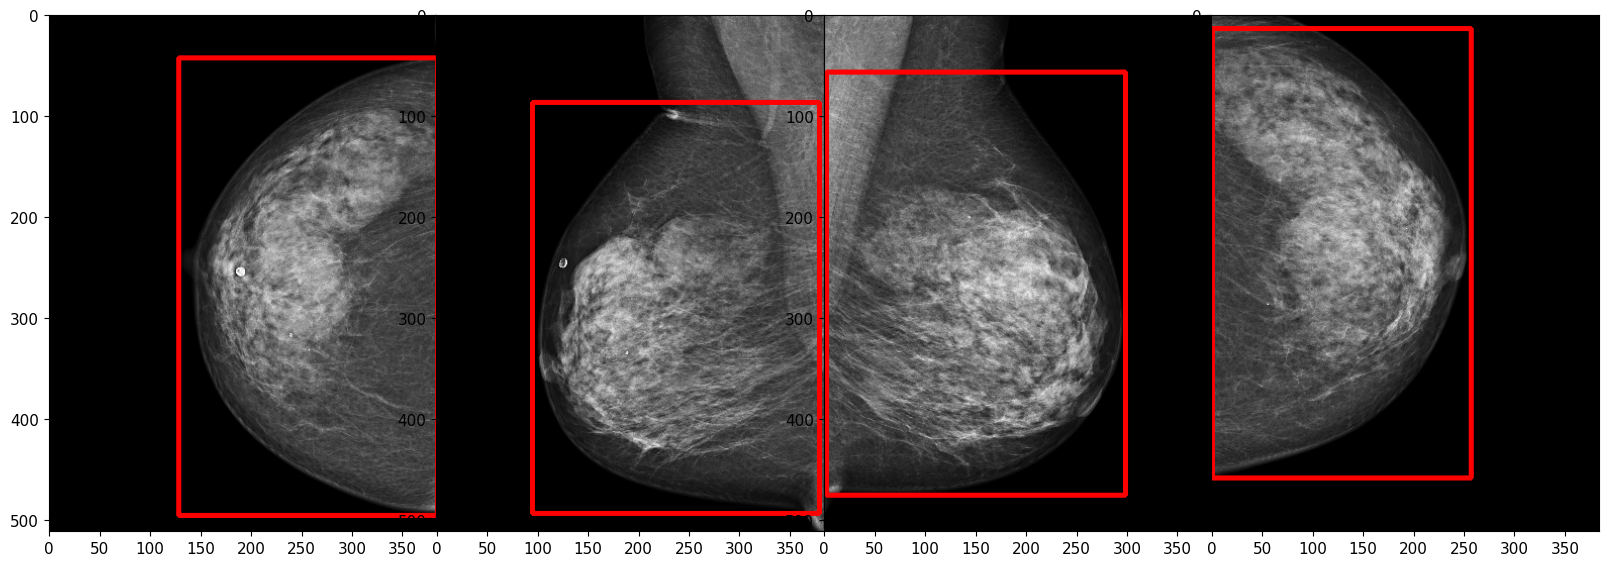

In [ ]:
fig, axis = plt.subplots(1, 4, figsize=(20,20))
axis = axis.flatten()
    
for i, image in enumerate(images):
    axis[i].imshow(image)

plt.subplots_adjust(wspace=0, hspace=.2)
plt.show()

# Convert All the JP2000 images to ROI-extracted

In [39]:
# === CONFIG ===
RESIZE_TO = 512
SAVE_DIR = f"train_image_ROI_processed_jp2000_{RESIZE_TO}"
parent_dir = r"E:\rsna-breast-cancer-detection"

# Gather all .jp2 paths
all_jp2_files = list(
    Path(os.path.join(parent_dir, "train_image_processed_jp2000_512")).rglob("*.jp2")
)
fail_counter = Counter()
model.eval()

# === CLEANING ===
def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

# === RESIZE ===
def image_resize(image, width=None, height=None):
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = resize(image, (dim[1], dim[0]), preserve_range=True, anti_aliasing=True)
    return resized.astype(np.uint8)

# === MAIN PROCESSING FUNCTION ===
def extract_and_roi(path):
    try:
        if not path.exists() or not path.is_file():
            fail_counter["invalid_path"] += 1
            print(f"[ERROR] Invalid path: {path}")
            return
        
        parent_folder = path.parent.name
        save_subdir = os.path.join(parent_dir, SAVE_DIR, parent_folder)
        os.makedirs(save_subdir, exist_ok=True)

        image = plt.imread(str(path))
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)
        
        # Ensure image loaded correctly
        if image is None:
            raise ValueError("Could not load image")
        
        # Check if the image is valid
        if image.shape[0] == 0 or image.shape[1] == 0:
            fail_counter["invalid_image"] += 1
            print(f"[ERROR] Image is empty: {path}")
            return
        
        results = model(image)
        detections = results.pandas().xyxy[0]
        
        if len(detections) == 0:
            fail_counter["no_roi"] += 1
            return

        for i, det in detections.iterrows():
            x1, y1, x2, y2 = map(int, [det["xmin"], det["ymin"], det["xmax"], det["ymax"]])
            
            # Check for valid ROI dimensions
            if x1 < 0 or y1 < 0 or x2 > image.shape[1] or y2 > image.shape[0]:
                fail_counter["invalid_roi"] += 1
                print(f"[ERROR] Invalid ROI for {path}: {x1}, {y1}, {x2}, {y2}")
                continue
            
            roi = image[y1:y2, x1:x2]
            roi_resized = image_resize(roi, width=RESIZE_TO)
            
            save_path = os.path.join(save_subdir, f"{path.stem}.jp2")
            try:
                imageio.imwrite(save_path, roi_resized, format='JP2')
            except Exception as e:
                print(f"[ERROR] Failed to save ROI for {path}: {e}")
                fail_counter["save_error"] += 1

            # === For sanity Check === 
            # return save_path
        
            # Clean up memory
            cleanup()

    except Exception as e:
        print(f"[ERROR] Failed processing {path} — {e}")
        fail_counter["fail"] += 1

# === Sanity Check ===
# for path in tqdm(all_jp2_files[:1], desc="Sanity Check"):
#     save_path = extract_and_roi(path)
#     img = plt.imread(save_path)
#     plt.imshow(img, cmap="turbo")
#     print("✅ Sanity check complete.")
#     print(f"image size = {img.shape}")
    
#     plt.axis('off')
#     plt.show()
#     break

# === RUN ===
Parallel(n_jobs=16, backend="loky", prefer="threads")(
    delayed(extract_and_roi)(path) for path in tqdm(all_jp2_files)
)

print(f"✅ Done! Processed {len(all_jp2_files)} images.")
print(f"❌ Failed: {fail_counter['fail']}, ",
      f"No ROI: {fail_counter['no_roi']}, ",
      f"Invalid Path: {fail_counter['invalid_path']}, ",
      f"Invalid Image: {fail_counter['invalid_image']}," 
      f"Save Errors: {fail_counter['save_error']}")

100%|██████████| 54706/54706 [1:45:11<00:00,  8.67it/s]


✅ Done! Processed 54706 images.
❌ Failed: 0,  No ROI: 0,  Invalid Path: 0,  Invalid Image: 0,Save Errors: 0


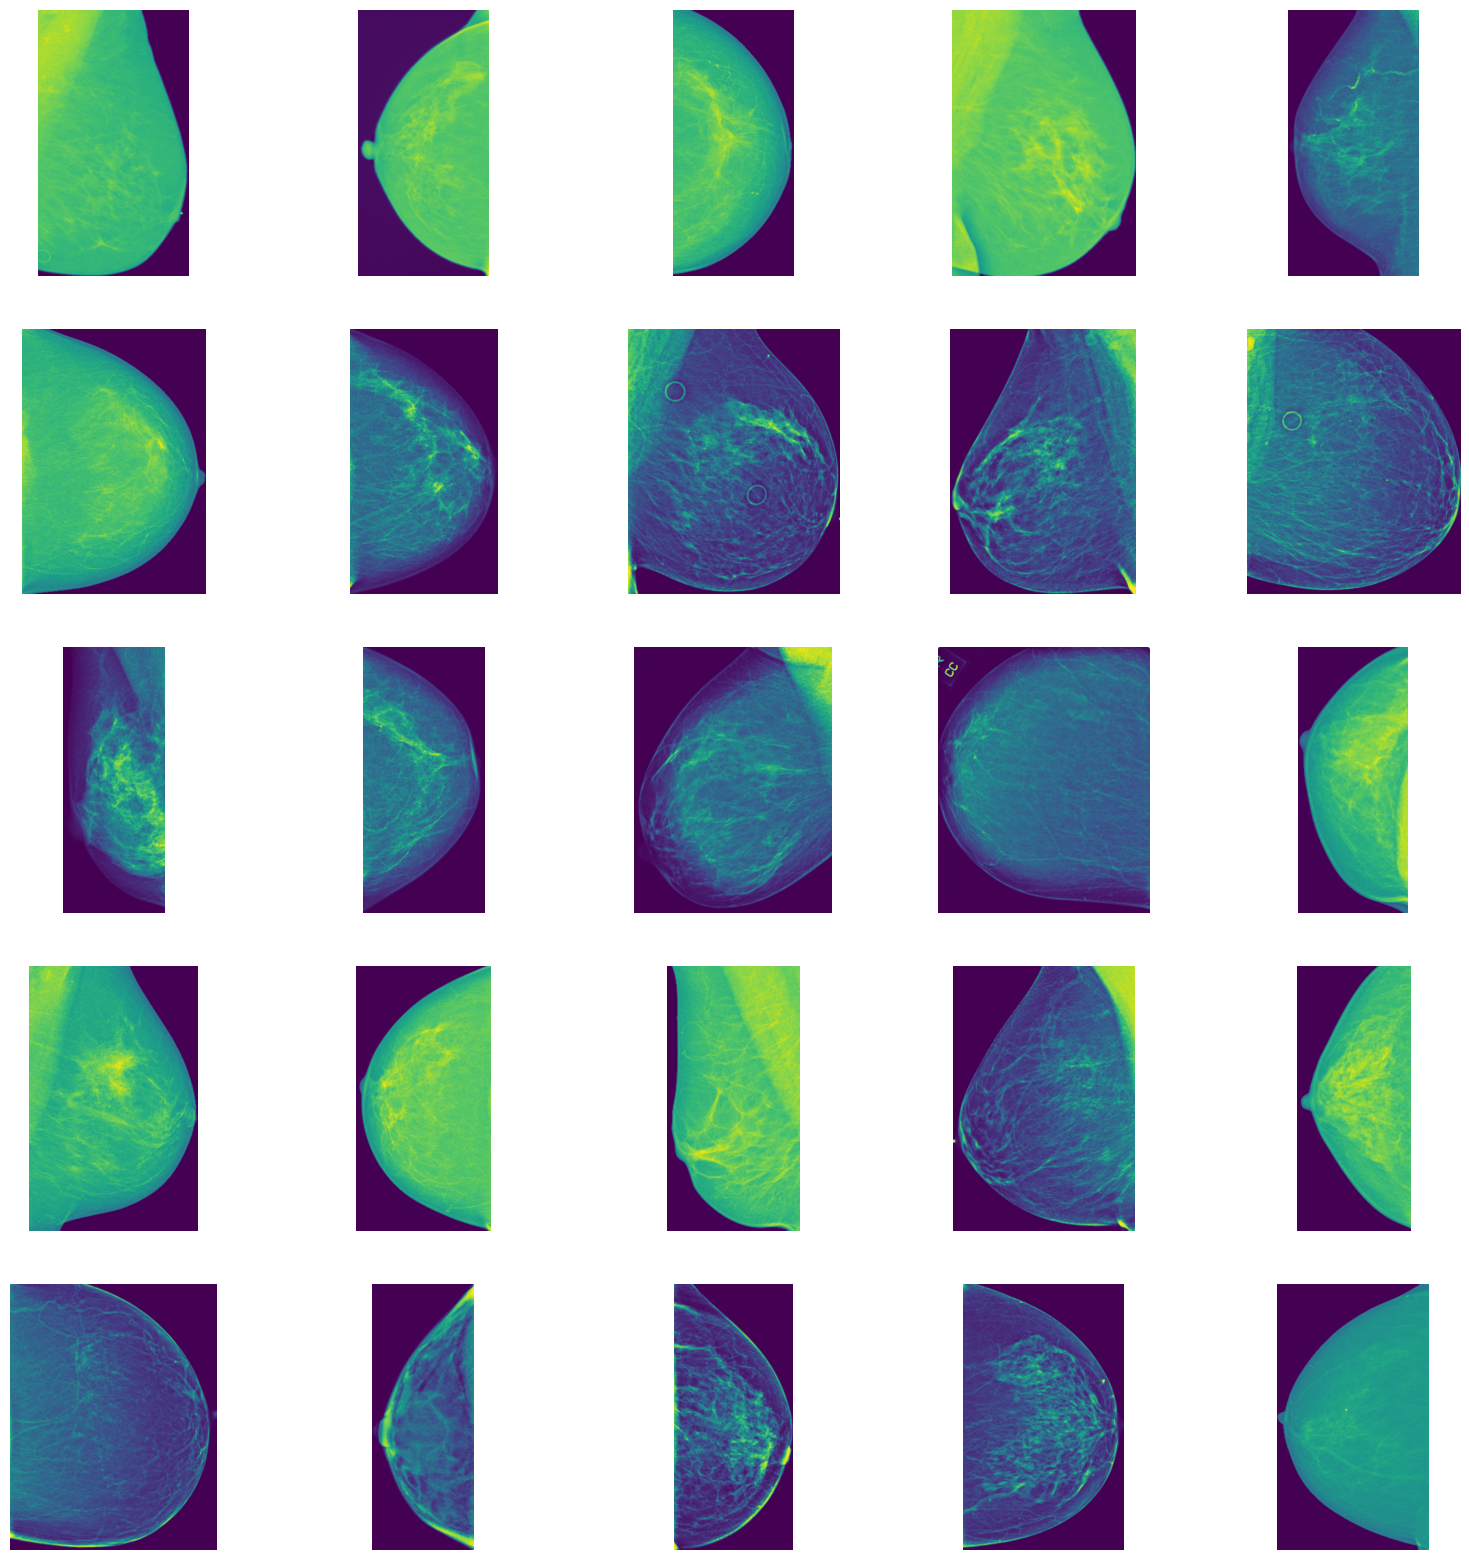

In [43]:
%matplotlib inline
paths = []
torch.cuda.empty_cache()
file_list = glob(
    os.path.join(parent_dir, "train_image_ROI_processed_jp2000_512", "*", "*.jp2")
)

for path in random.sample(file_list, 25):
    paths.append(path)
    
fig, axes = plt.subplots(5, 5, figsize=(20,20))
    
for idx, path in enumerate(paths):
    img = plt.imread(path)
    i = idx % 5 
    j = idx // 5 
    axes[i, j].imshow(img)
    axes[i, j].axis('off')

plt.subplots_adjust(wspace=0, hspace=.2)
plt.show()

### Check for missing jp2 ROI extracted images

In [42]:
train_df = pd.read_csv(os.path.join(parent_dir, "train.csv"))
# train_image_path = os.path.join(parent_dir, "train_image_processed_cv2_512")
train_image_path = os.path.join(parent_dir, "train_image_processed_cv2_512")

all_paths = []
for k in tqdm(range(len(train_df))):
    row = train_df.iloc[k, :]
    all_paths.append(
        os.path.join(
            # train_image_path, str(row.patient_id), f"{str(row.image_id)}.png"
            train_image_path, str(row.patient_id), f"{str(row.image_id)}.png"
        ) 
    )
    
train_df['path'] = all_paths

roi_dir = os.path.join(parent_dir, "train_image_ROI_processed_jp2000_512")

# Load train.csv and construct expected paths
train_df = pd.read_csv(os.path.join(parent_dir, "train.csv"))
expected_paths = [
    os.path.join(roi_dir, str(row.patient_id), f"{str(row.image_id)}.jp2")
    for _, row in train_df.iterrows()
]

# Get actual .jp2 paths that exist
actual_paths = set(p.as_posix() for p in Path(roi_dir).rglob("*.jp2"))
expected_paths_set = set(Path(p).as_posix() for p in expected_paths)

# Compare
missing_paths = expected_paths_set - actual_paths

print(f"🔍 Total expected: {len(expected_paths_set)}")
print(f"✅ Found: {len(actual_paths)}")
print(f"❌ Missing: {len(missing_paths)}")

# Optional: show a few missing examples
for p in list(missing_paths)[:10]:
    print("🚫 Missing:", p)

# Save to file for debugging
with open("missing_jp2_paths.txt", "w") as f:
    for p in missing_paths:
        f.write(p + "\n")

100%|██████████| 54706/54706 [00:03<00:00, 14536.74it/s]


🔍 Total expected: 54706
✅ Found: 54611
❌ Missing: 95
🚫 Missing: E:/rsna-breast-cancer-detection/train_image_ROI_processed_jp2000_512/17960/737473351.jp2
🚫 Missing: E:/rsna-breast-cancer-detection/train_image_ROI_processed_jp2000_512/52509/930239507.jp2
🚫 Missing: E:/rsna-breast-cancer-detection/train_image_ROI_processed_jp2000_512/33581/1398764972.jp2
🚫 Missing: E:/rsna-breast-cancer-detection/train_image_ROI_processed_jp2000_512/33084/1990776518.jp2
🚫 Missing: E:/rsna-breast-cancer-detection/train_image_ROI_processed_jp2000_512/38739/1632645203.jp2
🚫 Missing: E:/rsna-breast-cancer-detection/train_image_ROI_processed_jp2000_512/51115/1906555893.jp2
🚫 Missing: E:/rsna-breast-cancer-detection/train_image_ROI_processed_jp2000_512/665/2030700146.jp2
🚫 Missing: E:/rsna-breast-cancer-detection/train_image_ROI_processed_jp2000_512/16488/1712612317.jp2
🚫 Missing: E:/rsna-breast-cancer-detection/train_image_ROI_processed_jp2000_512/25323/1743461841.jp2
🚫 Missing: E:/rsna-breast-cancer-detection